# Create zonal statistics and point extractions for comparing CONUS404 and reference datasets

<img src='../../../doc/assets/Eval_Analysis.svg' width=600>

Now that the data has been prepared, it is time to compute zonal statistics and perform point extractions. 

<details>
  <summary>Guide to pre-requisites and learning outcomes...&lt;click to expand&gt;</summary>
  
  <table>
    <tr>
      <td>Pre-Requisites
      <td>To get the most out of this notebook, you should already have an understanding of these topics: 
        <ul>
        <li>the following summary statistics: mean, median, standard deviation, bias, mean absolute error (MAE), root mean squared error (RMSE), Pearson and Spearman correlation coefficients, and percent bias.
        <li>the HUC (Hydrologic Unit Code) system of identification of drainage basins used by the USGS, in particular the HUC6 designation used here.
        </ul>
    <tr>
      <td>Expected Results
      <td>At the end of this notebook, you will produce: 
        <ul>
        <li>Tables of descriptive statistics for the Delaware River Basin for each HUC6 designation within the basin, for forcing and reference datasets of precipitation, temperature, and net radiation.
        <li>Further processed datasets for subsequent use in a separate visualization notebook
        </ul>
  </table>
</details>

## Introduction

The evaluation of forcings data can be performed either directly to some observational or reference data, or indirectly. An example of an indirect evaluation is to use multiple forcing datasets to drive a hydrological model and compare simulated outputs with observations (e.g., streamflow to gaged streamflow) to assess the influence of different forcing data on hydrologic model outputs. Indirect approaches are computationally expensive, thus we demonstrate in this notebook how to perform a direct evaluation of forcing data to multiple reference datasets. The methods for a direct evaluation consist of calculating descriptive and comparative statistics between forcing and reference datasets for several variables (precipitation, temperature, and net radiation).  

### How does this notebook evaluate forcing data?
First, data from gridded datasets (forcing: CONUS404; reference: PRISM, CERES-EBAF) are spatially summarized by computing area-weighted means over HUC6 spatial units within the Delaware River Basin. Next, annual means are computed over consistent periods of record. From these, some commonly-used descriptive statistics are calculated and tabulated. Similarly, annual means of point (station-based) reference data (GHCN, CRN) and annual means of forcing data extracted from nearest (to station) grid-points are computed, and descriptive statistics calculated and tabulated. For further evaluation and visualization, data processed within the notebook are output for subsequent use by a separate visualization notebook (see graphic above).
    
The following statistics will be calculated for comparative analysis between CONUS404 and each reference dataset:

<ul>
    <li>mean</li>
    <li>median</li>
    <li>standard deviation (stdev)</li>
    <li>bias</li>
    <li>mean absolute error (mae)</li>
    <li>root-mean square error (rmse)</li>
    <li>Pearson's correlation</li>
    <li>Spearman's correlation</li>
    <li>percent bias (pbias)</li>
</ul>


### Data References
- [CONUS404 (**CON**tiguous United States for **40** years at **4**-km resolution)](https://doi.org/10.5066/P9PHPK4F)
- [PRISM (**P**arameter-elevation **R**egressions on **I**ndependent **S**lopes **M**odel)](https://prism.oregonstate.edu/)
- [CERES-EBAF (**C**louds and **E**arth's **R**adiant **E**nergy **S**ystems - **E**nergy **B**alanced **A**nd **F**illed)](https://ceres.larc.nasa.gov/data/)
- [GHCN (**G**lobal **H**istorical **C**limate **N**etwork)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily)
- [CRN (**C**limate **R**eference **N**etwork)](https://www.ncei.noaa.gov/products/land-based-station/us-climate-reference-network)


In [1]:
# library imports
import os
import cf_xarray
import dask
import dask 
from dask.distributed import LocalCluster, Client
import fsspec
import gdptools
import geopandas as gpd
import hvplot.xarray
import hvplot.pandas
import intake
import math
import numpy as np
import pandas as pd
from pygeohydro import WBD
import sparse
import warnings
import xarray as xr

from shapely.geometry import Polygon

warnings.filterwarnings('ignore')

We will use the standard statistical metrics for our comparative statistics.

In [2]:
# run script for available functions from the standard suite
%run ../../../evaluation/Metrics_StdSuite_v1.ipynb

# run script for additional functions that will be used
%run ../../../evaluation/Metrics_Misc_v1.ipynb

Using the `intake` catalog, we will load CONUS404 data for the Delaware River Basin

In [3]:
# data
# connect to HyTEST catalog
url = 'https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/hytest_intake_catalog.yml'
cat = intake.open_catalog(url)

# access tutorial catalog
conus404_drb_cat = cat["conus404-drb-eval-tutorial-catalog"]
list(conus404_drb_cat)

['ceres-drb-OSN',
 'conus404-drb-OSN',
 'crn-drb-OSN',
 'hcn-drb-OSN',
 'prism-drb-OSN']

## **Start a Dask client using an appropriate Dask Cluster** 
This is an optional step, but can speed up data loading significantly, especially when accessing data from the cloud.

### Setup your client on your local PC or on HPC like this:

In [4]:
# check for existing Dask cluster
if "client" in locals():
    print("Shutting down existing Dask cluster.")
    cluster.close()
    client.close()

cluster = LocalCluster()
client = Client(cluster)

print(f"The link to the Dask dashboard is {client.dashboard_link}. If on HPC, this may not be available.")

The link to the Dask dashboard is http://127.0.0.1:8787/status. If on HPC, this may not be available.


Workflow outline:
1. Read in the prepared dataset
2. Read in the HUC6 boundaries and transform to same coordinate reference system as prepared dataset
3. Make a data mask with the HUC6 boundaries to calculate zonal statistics
4. Compute zonal statistics with data mask and prepared data

Once all calculations are done: 

5. Combine each reference with benchmark into single dataset
6. Export gridded data zonal statistics
<br>

## **Compute zonal statistics for gridded datasets**

In the last tutorial, we prepared three gridded datasets: CONUS404 (benchmark), PRISM (reference), and CERES-EBAF (reference). The goal of this section is compute [zonal statistics](https://gisgeography.com/zonal-statistics/) for each HUC6 zone in the Delaware River Basin (DRB) by using the [conservative regridding method put forth by Ryan Abernathy](https://discourse.pangeo.io/t/conservative-region-aggregation-with-xarray-geopandas-and-sparse/2715) to regrid and perform an area-weighted analysis.

Dataset outline:
<ol>
    <li>Read in the prepared dataset</li>
    <li>Compute bounding bands for grid cells then use these to create polygons in area-preserving CRS</li>
    <li>Read in the HUC6 boundaries and transform to same coordinate reference system as prepared dataset</li>
    <li>Overlay the dataset polygons over the HUC6 boundaries and create spatial weights matrices</li>
    <li>Perform matrix multiplication between The prepared dataset and the spatial weights matrices</li>
</ol>

The following two functions will be used for regridding each dataset. An explanation of what they do will be provided when they are applied.

In [5]:
def bounds_to_poly(x_bounds, y_bounds):
    """Return a polygon based on the x (longitude) and
    y (longitude) bounding band DataArrays."""
    return Polygon([
        (x_bounds[0], y_bounds[0]),
        (x_bounds[0], y_bounds[1]),
        (x_bounds[1], y_bounds[1]),
        (x_bounds[1], y_bounds[0])
    ])

def apply_weights_matmul_sparse(weights, data):
    """Apply weights in a sparse matrices to data and regrid"""
    assert isinstance(weights, sparse.SparseArray)
    assert isinstance(data, np.ndarray)
    data = sparse.COO.from_numpy(data)
    data_shape = data.shape
    n, k = data_shape[0], data_shape[1] * data_shape[2]
    data = data.reshape((n, k))
    weights_shape = weights.shape
    k_, m = weights_shape[0] * weights_shape[1], weights_shape[2]
    assert k == k_
    weights_data = weights.reshape((k, m))

    regridded = sparse.matmul(data, weights_data)
    assert regridded.shape == (n, m)
    return regridded.todense()

    assert isinstance(weights, sparse.SparseArray)
    assert isinstance(data, np.ndarray)
    data = sparse.COO.from_numpy(data)
    data_shape = data.shape
    # k = nlat * nlon
    n, k = data_shape[0], data_shape[1] * data_shape[2]
    data = data.reshape((n, k))
    weights_shape = weights.shape
    k_, m = weights_shape[0] * weights_shape[1], weights_shape[2]
    assert k == k_
    weights_data = weights.reshape((k, m))

    regridded = sparse.matmul(data, weights_data)
    assert regridded.shape == (n, m)
    return regridded.todense()

And the following `fsspec.filesystem` will be using to read in each dataset from an [Open Storage Network](https://www.openstoragenetwork.org/) bucket, which is read only.

In [6]:
# x and y below are syntatically longitude (x) and latitude (y) in the datasets
x = "x"
y = "y"

**CONUS404 zonal statistics**

#### 1. Read in the HUC6 boundaries and transform to same coordinate reference system as prepared dataset

In [7]:
# bring in HUC6 boundaries found in the DRB
drb_wbd = WBD(layer="huc6", outfields=["huc6", "name"])
drb_gdf = drb_wbd.byids("huc6",  ["020401", "020402"])

In [8]:
# view the dataframe
drb_gdf.head()

,geometry,huc6,name
0,"POLYGON ((-74.59840 42.45930, -74.60130 42.461...",020401,Upper Delaware
1,"POLYGON ((-75.93127 40.88437, -75.93681 40.885...",020402,Lower Delaware


In [9]:
# area preserving coordinate reference system
crs_area = "ESRI:53034"

# set CRS to match c404_drb
drb_gdf = drb_gdf.to_crs(crs_area)

In [10]:
# visualize
drb_gdf.hvplot(line_color="orange", color="purple", line_width=2.5)

:Polygons   [x,y]

#### 2. Read CONUS404 data, previously processed over the DRB

In [13]:
conus404_drb_cat['conus404-drb-OSN'].kwargs['decode_coords'] = 'all'
conus404_drb_cat['conus404-drb-OSN'].kwargs

{'chunks': {}, 'consolidated': True, 'decode_coords': 'all'}

In [14]:
# open dataset
c404_drb = conus404_drb_cat['conus404-drb-OSN'].to_dask()

# crs
c404_crs = c404_drb.rio.crs.to_proj4()

c404_drb

<xarray.Dataset>
Dimensions:      (time: 517, y: 105, x: 47)
Coordinates:
    crs          int64 ...
    lat          (y, x) float32 dask.array<chunksize=(105, 47), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(105, 47), meta=np.ndarray>
  * time         (time) datetime64[ns] 1979-10-31 1979-11-30 ... 2022-10-31
  * x            (x) float64 1.768e+06 1.772e+06 ... 1.948e+06 1.952e+06
  * y            (y) float64 2e+05 2.04e+05 2.08e+05 ... 6.12e+05 6.16e+05
Data variables:
    PREC_ACC_NC  (time, y, x) float32 dask.array<chunksize=(1, 105, 47), meta=np.ndarray>
    RNET         (time, y, x) float32 dask.array<chunksize=(1, 105, 47), meta=np.ndarray>
    TK           (time, y, x) float32 dask.array<chunksize=(1, 105, 47), meta=np.ndarray>
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

In [ ]:
# visualize (uncomment to view)
# c404_drb.PREC_ACC_NC.hvplot(x="x", y="y", rasterize=True)

#### 3. Compute bounding bands for grid cells and use them to create polygons in area-preserving CRS

Create the grid of c404_drb using any of the variables

In [15]:
# set var
c404_var = "TK"

# drop unneeded variable and coordinates
c404_grid = c404_drb[[c404_var]].drop(['time', 'lon', 'lat', c404_var]).reset_coords()
c404_grid

<xarray.Dataset>
Dimensions:  (x: 47, y: 105)
Coordinates:
  * x        (x) float64 1.768e+06 1.772e+06 1.776e+06 ... 1.948e+06 1.952e+06
  * y        (y) float64 2e+05 2.04e+05 2.08e+05 ... 6.08e+05 6.12e+05 6.16e+05
Data variables:
    crs      int64 ...
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

And create bounding bands then stack into points

In [16]:
# add bounds
c404_grid = c404_grid.cf.add_bounds(x)
c404_grid = c404_grid.cf.add_bounds(y)

# stack
c404_points = c404_grid.stack(point=(y, x))
c404_points

<xarray.Dataset>
Dimensions:   (bounds: 2, point: 4935)
Coordinates:
    x_bounds  (bounds, point) float64 1.766e+06 1.77e+06 ... 1.95e+06 1.954e+06
    y_bounds  (bounds, point) float64 1.98e+05 1.98e+05 ... 6.18e+05 6.18e+05
  * point     (point) object MultiIndex
  * y         (point) float64 2e+05 2e+05 2e+05 ... 6.16e+05 6.16e+05 6.16e+05
  * x         (point) float64 1.768e+06 1.772e+06 ... 1.948e+06 1.952e+06
Dimensions without coordinates: bounds
Data variables:
    crs       int64 ...
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

Next, use the `xarray apply_ufunc` function to apply the `bounds_to_poly` function above to the _c404_points_ DataSet.

In [17]:
c404_boxes = xr.apply_ufunc(
    bounds_to_poly,
    c404_points.x_bounds,
    c404_points.y_bounds,
    input_core_dims=[("bounds",),  ("bounds",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)
c404_boxes

<xarray.DataArray (point: 4935)>
array([<POLYGON ((1766000 198000, 1766000 202000, 1770000 202000, 1770000 198000, 1...>,
       <POLYGON ((1770000 198000, 1770000 202000, 1774000 202000, 1774000 198000, 1...>,
       <POLYGON ((1774000 198000, 1774000 202000, 1778000 202000, 1778000 198000, 1...>,
       ...,
       <POLYGON ((1942000 614000, 1942000 618000, 1946000 618000, 1946000 614000, 1...>,
       <POLYGON ((1946000 614000, 1946000 618000, 1950000 618000, 1950000 614000, 1...>,
       <POLYGON ((1950000 614000, 1950000 618000, 1954000 618000, 1954000 614000, 1...>],
      dtype=object)
Coordinates:
  * point    (point) object MultiIndex
  * y        (point) float64 2e+05 2e+05 2e+05 ... 6.16e+05 6.16e+05 6.16e+05
  * x        (point) float64 1.768e+06 1.772e+06 ... 1.948e+06 1.952e+06

Create geodataframe from boxes

In [18]:
c404_grid_df= gpd.GeoDataFrame(
    data={"geometry": c404_boxes.values, "y": c404_boxes[y], "x": c404_boxes[x]},
    index=c404_boxes.indexes["point"],
    crs=c404_crs
)
c404_grid_df

geometry  \
y        x                                                              
200000.0 1768000.0  POLYGON ((1766000.000 198000.000, 1766000.000 ...   
         1772000.0  POLYGON ((1770000.000 198000.000, 1770000.000 ...   
         1776000.0  POLYGON ((1774000.000 198000.000, 1774000.000 ...   
         1780000.0  POLYGON ((1778000.000 198000.000, 1778000.000 ...   
         1784000.0  POLYGON ((1782000.000 198000.000, 1782000.000 ...   
...                                                               ...   
616000.0 1936000.0  POLYGON ((1934000.000 614000.000, 1934000.000 ...   
         1940000.0  POLYGON ((1938000.000 614000.000, 1938000.000 ...   
         1944000.0  POLYGON ((1942000.000 614000.000, 1942000.000 ...   
         1948000.0  POLYGON ((1946000.000 614000.000, 1946000.000 ...   
         1952000.0  POLYGON ((1950000.000 614000.000, 1950000.000 ...   

                           y          x  
y        x                               
200000.0 1768000.0  200000.0  1768000.0  
         1772000.0  200000.0  1772000.0  
         1776000.0  200000.0  1776000.0  
         1780000.0  200000.0  1780000.0  
         1784000.0  200000.0  1784000.0  
...                      ...        ...  
616000.0 1936000.0  616000.0  1936000.0  
         1940000.0  616000.0  1940000.0  
         1944000.0  616000.0  1944000.0  
         1948000.0  616000.0  1948000.0  
         1952000.0  616000.0  1952000.0  

[4935 rows x 3 columns]

In [ ]:
# visualize (uncomment to view)
# c404_grid_df.hvplot(edgecolor="red", facecolor="white", linewidth=0.05)

#### 4. Overlay the dataset polygons we just created over the HUC6 boundaries and create spatial weights matrices

In [19]:
# convert DRB to conus404 crs
c404_drb_gdf = drb_gdf.to_crs(c404_crs)

#perform overlay
c404_overlay = c404_grid_df.overlay(c404_drb_gdf, keep_geom_type=True)
c404_overlay.head()

,y,x,huc6,name,geometry
0,200000.0,1904000.0,020402,Lower Delaware,"POLYGON ((1906000.000 202000.000, 1906000.000 ..."
1,200000.0,1908000.0,020402,Lower Delaware,"POLYGON ((1906000.000 202000.000, 1910000.000 ..."
2,200000.0,1912000.0,020402,Lower Delaware,"POLYGON ((1910000.000 202000.000, 1911904.532 ..."
3,204000.0,1900000.0,020402,Lower Delaware,"MULTIPOLYGON (((1902000.000 203994.681, 190173..."
4,204000.0,1904000.0,020402,Lower Delaware,"POLYGON ((1902000.000 205303.661, 1902003.249 ..."


<Axes: >

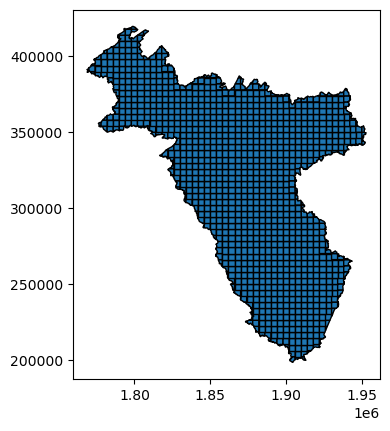

In [20]:
# plot overlay for single HUC6
c404_overlay[c404_overlay.huc6 == "020402"].geometry.plot(edgecolor='k')

Compute grid cell fractions. 

A cell fraction is defined as the area of the grid cell divided by the area of the target polygon (HUC6).

In [21]:
c404_grid_cell_fraction = (c404_overlay.geometry.area.groupby(c404_overlay.huc6)
                           .transform(lambda x: x / x.sum()))

Sparse DataArray (for an in-depth description of sparse data, see [this article](https://www.techopedia.com/definition/9480/sparse-array#:~:text=17%20May%2C%202017-,What%20Does%20Sparse%20Array%20Mean%3F,array%20in%20digital%20data%20handling.))

In [22]:
c404_multi_index = c404_overlay.set_index([y, x, "huc6"]).index
c404_df_weights = pd.DataFrame({"weights": c404_grid_cell_fraction.values},
                               index=c404_multi_index)

# create xarray dataset
c404_ds_weights = xr.Dataset(c404_df_weights)

# generate sparse data array
c404_weights_sparse = c404_ds_weights.unstack(sparse=True, fill_value=0.).weights

#### 5. Perform matrix multiplication between the prepared dataset and the spatial weights matrices

Matrix multiplication across each DataArray. We do this for precipitation ('PREC_ACC_NC'), net radiation ('RNET'), and temperature ('TK').

In [23]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):

    # precipitation
    c404_precip_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        c404_weights_sparse,
        c404_drb["PREC_ACC_NC"],
        join="left",
        input_core_dims=[["y", "x", "huc6"], ["y", "x"]],
        output_core_dims=[["huc6"]],
        dask="parallelized",
        meta=[np.ndarray((0,))]
    )

    # net radiation
    c404_rnet_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        c404_weights_sparse,
        c404_drb["RNET"],
        join="left",
        input_core_dims=[["y", "x", "huc6"], ["y", "x"]],
        output_core_dims=[["huc6"]],
        dask="parallelized",
        meta=[np.ndarray((0,))]
    )

    # temperature
    c404_tk_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        c404_weights_sparse,
        c404_drb["TK"],
        join="left",
        input_core_dims=[["y", "x", "huc6"], ["y", "x"]],
        output_core_dims=[["huc6"]],
        dask="parallelized",
        meta=[np.ndarray((0,))]
    )

Merge DataArrays into Dataset

In [24]:
c404_regridded = xr.Dataset({"PREC_NC_ACC": c404_precip_regridded,
                             "RNET": c404_rnet_regridded,
                             "TK": c404_tk_regridded})
c404_regridded = c404_regridded.drop("crs")
c404_regridded.attrs = c404_drb.attrs
c404_regridded

<xarray.Dataset>
Dimensions:      (huc6: 2, time: 517)
Coordinates:
  * huc6         (huc6) object '020401' '020402'
  * time         (time) datetime64[ns] 1979-10-31 1979-11-30 ... 2022-10-31
Data variables:
    PREC_NC_ACC  (time, huc6) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    RNET         (time, huc6) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    TK           (time, huc6) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

Covert to DataFrame. Now we see we have our timeseries for each variable and each HU06 within DRB.

In [25]:
c404_df = c404_regridded.to_dataframe()
c404_df

PREC_NC_ACC        RNET          TK
huc6   time                                           
020401 1979-10-31    92.347106   53.836499  281.937662
       1979-11-30    94.338399   20.707014  278.364816
       1979-12-31    48.669171    8.188753  271.370165
       1980-01-31    51.166572    8.634619  267.390965
       1980-02-29    39.551063   37.497082  265.023723
...                        ...         ...         ...
020402 2022-06-30    98.177848  191.787350  295.226971
       2022-07-31    78.151746  180.768256  299.089277
       2022-08-31    96.719828  159.768490  298.274521
       2022-09-30    63.366276  102.287688  293.287686
       2022-10-31     0.017557  -48.117960  289.640533

[1034 rows x 3 columns]

Let's clean up our data. We will reset our index and modify our dates to represent the year-month instead of reporting on the last day of the year.

In [26]:
# reset index
c404_zonal_stats = c404_df.reset_index(drop=False)

# convert time to string and remove days
c404_zonal_stats["time"] = c404_zonal_stats["time"].astype(str).str[:-3]

# drop 1979 as it only had three months of data
c404_zonal_stats = (c404_zonal_stats[c404_zonal_stats['time']
                                     .str.contains("1979") == False])

c404_zonal_stats

,huc6,time,PREC_NC_ACC,RNET,TK
3,020401,1980-01,51.166572,8.634619,267.390965
4,020401,1980-02,39.551063,37.497082,265.023723
5,020401,1980-03,180.614316,71.697241,271.726642
6,020401,1980-04,133.649421,117.075991,279.958756
7,020401,1980-05,50.195687,167.817963,287.487071
...,...,...,...,...,...
1029,020402,2022-06,98.177848,191.787350,295.226971
1030,020402,2022-07,78.151746,180.768256,299.089277
1031,020402,2022-08,96.719828,159.768490,298.274521
1032,020402,2022-09,63.366276,102.287688,293.287686


**PRISM zonal statistics**

Now, in the next cell, we'll run through the same steps to compute zonal statistics for the two PRISM variables, temperature (TK) and precipitation (PREC_ACC_NC).

In [36]:
conus404_drb_cat['prism-drb-OSN'].kwargs['decode_coords'] = 'all'
prism_drb = conus404_drb_cat['prism-drb-OSN'].to_dask()
prism_drb = prism_drb.chunk(dict(x=-1))
prism_drb

<xarray.Dataset>
Dimensions:      (time: 495, y: 92, x: 50)
Coordinates:
  * time         (time) datetime64[ns] 1979-10-01 1979-11-01 ... 2020-12-01
  * x            (x) float32 -76.4 -76.35 -76.31 -76.27 ... -74.44 -74.4 -74.35
  * y            (y) float32 42.48 42.44 42.4 42.35 ... 38.81 38.77 38.73 38.69
Data variables:
    PREC_ACC_NC  (time, y, x) float64 dask.array<chunksize=(492, 92, 50), meta=np.ndarray>
    TK           (time, y, x) float32 dask.array<chunksize=(492, 92, 50), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4

In [37]:
# open dataset
conus404_drb_cat['prism-drb-OSN'].kwargs['decode_coords'] = 'all'
prism_drb = conus404_drb_cat['prism-drb-OSN'].to_dask()
prism_drb = prism_drb.chunk(dict(x=-1))

# prism crs
prism_crs = 4269 # EPSG:4269 = NAD83

# create the grid of c404_drb using any of the variables
prism_var = "TK"

# drop unneeded variable and coordinates
prism_grid = prism_drb[[prism_var]].drop(
    ['time', prism_var]).reset_coords().load()


# add bounds
prism_grid = prism_grid.cf.add_bounds(x)
prism_grid = prism_grid.cf.add_bounds(y)

# stack
prism_points = prism_grid.stack(point=(y, x))

# apply bounds_to method
prism_boxes = xr.apply_ufunc(
    bounds_to_poly,
    prism_points.x_bounds,
    prism_points.y_bounds,
    input_core_dims=[("bounds",),  ("bounds",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)

# create geodataframe from boxes
prism_grid_df= gpd.GeoDataFrame(
    data={"geometry": prism_boxes.values,
          "y": prism_boxes[y],
          "x": prism_boxes[x]},
    index=prism_boxes.indexes["point"],
    crs=prism_crs
)

# convert DRB to conus404 crs
prism_drb_gdf = drb_gdf.to_crs(epsg=prism_crs)

# overlay the two grids
prism_overlay = prism_grid_df.overlay(prism_drb_gdf, keep_geom_type=True)

# grid cell fractions
prism_grid_cell_fraction = (prism_overlay.geometry.area.groupby(prism_overlay.huc6)
                            .transform(lambda x: x / x.sum()))

# create sparse dataarray
prism_multi_index = prism_overlay.set_index([y, x, "huc6"]).index
prism_df_weights = pd.DataFrame({"weights": prism_grid_cell_fraction.values},
                                index=prism_multi_index)

prism_ds_weights = xr.Dataset(prism_df_weights)

prism_weights_sparse = prism_ds_weights.unstack(sparse=True, fill_value=0.).weights

# Matrix multiplication across each DataArray
with dask.config.set(**{'array.slicing.split_large_chunks': False, 'allow_rechunk': True}):
    prism_precip_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        prism_weights_sparse,
        prism_drb["PREC_ACC_NC"],
        join="left",
        input_core_dims=[["y", "x", "huc6"], ["y", "x"]],
        output_core_dims=[["huc6"]],
        dask="parallelized",
        meta=[np.ndarray((0,))]
    )

    prism_tk_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        prism_weights_sparse,
        prism_drb["TK"],
        join="left",
        input_core_dims=[["y", "x", "huc6"], ["y", "x"]],
        output_core_dims=[["huc6"]],
        dask="parallelized",
        meta=[np.ndarray((0,))]
    )
# merge DataArrays into Dataset
prism_regridded = xr.Dataset({"PREC_NC_ACC": prism_precip_regridded,
                              "TK": prism_tk_regridded})
prism_regridded.attrs = prism_drb.attrs

# Covert to DataFrame
prism_df = prism_regridded.load().to_dataframe()
prism_df.head()

/home/alaws/miniforge3/envs/pangeo/lib/python3.10/site-packages/sparse/_common.py:209: RuntimeWarning: Nan will not be propagated in matrix multiplication
  warnings.warn("Nan will not be propagated in matrix multiplication", RuntimeWarning, stacklevel=1)
/home/alaws/miniforge3/envs/pangeo/lib/python3.10/site-packages/sparse/_common.py:209: RuntimeWarning: Nan will not be propagated in matrix multiplication
  warnings.warn("Nan will not be propagated in matrix multiplication", RuntimeWarning, stacklevel=1)
/home/alaws/miniforge3/envs/pangeo/lib/python3.10/site-packages/sparse/_common.py:209: RuntimeWarning: Nan will not be propagated in matrix multiplication
  warnings.warn("Nan will not be propagated in matrix multiplication", RuntimeWarning, stacklevel=1)
/home/alaws/miniforge3/envs/pangeo/lib/python3.10/site-packages/sparse/_common.py:209: RuntimeWarning: Nan will not be propagated in matrix multiplication
  warnings.warn("Nan will not be propagated in matrix multiplication", Runtim

PREC_NC_ACC          TK
huc6   time                               
020401 1979-10-01   126.210588  282.546819
       1979-11-01   109.397223  279.295506
       1979-12-01    49.585651  272.961811
       1980-01-01    27.716338  269.476313
       1980-02-01    28.548982  267.348098

Let's clean up the PRISM data as we have done with the CONUS404 data. We will reset the index and clean up the date formatting.

In [39]:
# reset index and add time back
prism_zonal_stats = prism_df.reset_index(drop=False)

# convert time to string and remove days
prism_zonal_stats["time"] = prism_zonal_stats["time"].astype(str).str[:-3]

prism_zonal_stats.head()

,huc6,time,PREC_NC_ACC,TK
0,020401,1979-10,126.210588,282.546819
1,020401,1979-11,109.397223,279.295506
2,020401,1979-12,49.585651,272.961811
3,020401,1980-01,27.716338,269.476313
4,020401,1980-02,28.548982,267.348098


In [54]:
prism_zonal_stats.to_parquet("../../../../hytest_data/prism_drb_zonal_stats.parquet", index=False)

### Descriptive statistics

We will now compute descriptive statistics between the previously computed CONUS404 and PRISM zonal statistics. The statistics that will be calculated are mean, median, standard deviation, bias, MAE, RMSE, Pearson's correlation, Spearman's r, and percent bias. 

The overall process will look like this:
1. Merge zonal stats together on HUC6 and time values
2. Resample data to 1 year means of monthly values
3. Calculate each statistic 

In [40]:
# Merge the PRISM and CONUS404 zonals stats together based on the HUC6 code and time
prism_c404_zonal = prism_zonal_stats.merge(c404_zonal_stats,
                                           left_on=['huc6', 'time'],
                                           right_on=['huc6', 'time'],
                                           suffixes=["_prism", "_c404"])

#drop RNET
prism_c404_zonal.drop("RNET", axis=1, inplace=True)

prism_c404_zonal.head()

,huc6,time,PREC_NC_ACC_prism,TK_prism,PREC_NC_ACC_c404,TK_c404
0,020401,1980-01,27.716338,269.476313,51.166572,267.390965
1,020401,1980-02,28.548982,267.348098,39.551063,265.023723
2,020401,1980-03,154.497410,273.322678,180.614316,271.726642
3,020401,1980-04,138.261927,281.506899,133.649421,279.958756
4,020401,1980-05,50.426499,287.710490,50.195687,287.487071


In [41]:
# convert time column to datetime type
prism_c404_zonal["time"] = pd.to_datetime(prism_c404_zonal["time"], format="%Y-%m")
prism_c404_zonal.head()

,huc6,time,PREC_NC_ACC_prism,TK_prism,PREC_NC_ACC_c404,TK_c404
0,020401,1980-01-01,27.716338,269.476313,51.166572,267.390965
1,020401,1980-02-01,28.548982,267.348098,39.551063,265.023723
2,020401,1980-03-01,154.497410,273.322678,180.614316,271.726642
3,020401,1980-04-01,138.261927,281.506899,133.649421,279.958756
4,020401,1980-05-01,50.426499,287.710490,50.195687,287.487071


In [42]:
# resample done by HUC6 as the index is HUC6 and year
prism_c404_yearly = prism_c404_zonal.resample("1Y", on="time").agg(
    {"PREC_NC_ACC_c404": "sum",
    "PREC_NC_ACC_prism": "sum",
    "TK_c404": "mean",
    "TK_prism": "mean"}
)

In [43]:
prism_c404_yearly.reset_index(drop=False, inplace=True)
prism_c404_yearly.head()

,time,PREC_NC_ACC_c404,PREC_NC_ACC_prism,TK_c404,TK_prism
0,1980-12-31,2090.117671,1826.957201,282.193407,283.004523
1,1981-12-31,2164.376781,2034.641688,282.296501,282.993985
2,1982-12-31,2223.466848,2079.528375,282.353011,282.962563
3,1983-12-31,3026.270091,2807.524624,283.164971,283.595566
4,1984-12-31,2691.473003,2400.246671,282.847075,283.316475


Here we calculate mean, median, and standard deviation of yearly data.

In [44]:
# mean, median, standard deviation
prism_c404_mean = prism_c404_yearly.mean()
prism_c404_median = prism_c404_yearly.median()
prism_c404_stdev = prism_c404_yearly.std()

#create dataframe
prism_c404_stats = pd.DataFrame({"annual_mean": prism_c404_mean,
                                 "median": prism_c404_median,
                                 "stdev": prism_c404_stdev}).T.drop("time", axis=1)

# reset index and rename
prism_c404_stats = prism_c404_stats.reset_index(drop=False).rename({"index": "stat"}, axis=1) #noqa : E501

prism_c404_stats

,stat,PREC_NC_ACC_c404,PREC_NC_ACC_prism,TK_c404,TK_prism
0,annual_mean,2592.067175,2432.027531,283.045967,283.622349
1,median,2557.207691,2402.311466,282.847075,283.474596
2,stdev,365.673858,376.414963,0.681543,0.623451


Now we calculate the bias

In [45]:
# bias
prism_c404_stats_annual_mean = prism_c404_stats.loc[prism_c404_stats['stat'] == "annual_mean"] #noqa : E501
prism_c404_bias_precip = float(prism_c404_stats_annual_mean["PREC_NC_ACC_c404"] - prism_c404_stats_annual_mean["PREC_NC_ACC_prism"]) #noqa : E501
prism_c404_bias_tk = float(prism_c404_stats_annual_mean["TK_c404"] - prism_c404_stats_annual_mean["TK_prism"]) #noqa : E501

# add stat to bottom of dataframe
prism_c404_stats.loc[len(prism_c404_stats.index)] = ["bias", prism_c404_bias_precip, None, prism_c404_bias_tk, None] #noqa : E501

prism_c404_stats

,stat,PREC_NC_ACC_c404,PREC_NC_ACC_prism,TK_c404,TK_prism
0,annual_mean,2592.067175,2432.027531,283.045967,283.622349
1,median,2557.207691,2402.311466,282.847075,283.474596
2,stdev,365.673858,376.414963,0.681543,0.623451
3,bias,160.039644,None,-0.576383,None


MAE and RMSE is then calculated

In [46]:
# MAE
prism_c404_mae_precip = sum(abs(prism_c404_yearly["PREC_NC_ACC_c404"] - prism_c404_yearly["PREC_NC_ACC_prism"]))/len(prism_c404_yearly) #noqa : E501
prism_c404_mae_tk = sum(abs(prism_c404_yearly["TK_c404"] - prism_c404_yearly["TK_prism"]))/len(prism_c404_yearly) #noqa : E501

# add stat to bottom of dataframe
prism_c404_stats.loc[len(prism_c404_stats.index)] = ["MAE", prism_c404_mae_precip, None, prism_c404_mae_tk, None] #noqa : E501

prism_c404_stats

,stat,PREC_NC_ACC_c404,PREC_NC_ACC_prism,TK_c404,TK_prism
0,annual_mean,2592.067175,2432.027531,283.045967,283.622349
1,median,2557.207691,2402.311466,282.847075,283.474596
2,stdev,365.673858,376.414963,0.681543,0.623451
3,bias,160.039644,None,-0.576383,None
4,MAE,190.936432,None,0.576383,None


In [47]:
# RMSE
prism_c404_rmse_precip = math.sqrt(np.square(np.subtract(prism_c404_yearly["PREC_NC_ACC_c404"], prism_c404_yearly["PREC_NC_ACC_prism"])).mean()) #noqa : E501
prism_c404_rmse_tk = math.sqrt(np.square(np.subtract(prism_c404_yearly["TK_c404"], prism_c404_yearly["TK_prism"])).mean()) #noqa : E501

# add stat to bottom of dataframe
prism_c404_stats.loc[len(prism_c404_stats.index)] = ["RMSE", prism_c404_rmse_precip, None, prism_c404_rmse_tk, None] #noqa : E501

prism_c404_stats

,stat,PREC_NC_ACC_c404,PREC_NC_ACC_prism,TK_c404,TK_prism
0,annual_mean,2592.067175,2432.027531,283.045967,283.622349
1,median,2557.207691,2402.311466,282.847075,283.474596
2,stdev,365.673858,376.414963,0.681543,0.623451
3,bias,160.039644,None,-0.576383,None
4,MAE,190.936432,None,0.576383,None
5,RMSE,234.917714,None,0.596919,None


In [48]:
# Pearsons correlation
prism_c404_pearson_precip = pearson_r(prism_c404_yearly["PREC_NC_ACC_c404"], prism_c404_yearly["PREC_NC_ACC_prism"]) #noqa : E501
prism_c404_pearson_tk = pearson_r(prism_c404_yearly["TK_c404"], prism_c404_yearly["TK_prism"]) #noqa : E501

# add stat to bottom of dataframe
prism_c404_stats.loc[len(prism_c404_stats.index)] = ["Pearson", prism_c404_pearson_precip, None, prism_c404_pearson_tk, None] #noqa : E501

prism_c404_stats

,stat,PREC_NC_ACC_c404,PREC_NC_ACC_prism,TK_c404,TK_prism
0,annual_mean,2592.067175,2432.027531,283.045967,283.622349
1,median,2557.207691,2402.311466,282.847075,283.474596
2,stdev,365.673858,376.414963,0.681543,0.623451
3,bias,160.039644,None,-0.576383,None
4,MAE,190.936432,None,0.576383,None
5,RMSE,234.917714,None,0.596919,None
6,Pearson,0.890306,None,0.974909,None


In [49]:
# Spearman's correlation
prism_c404_spearman_precip = spearman_r(prism_c404_yearly["PREC_NC_ACC_c404"], prism_c404_yearly["PREC_NC_ACC_prism"]) #noqa : E501
prism_c404_spearman_tk = spearman_r(prism_c404_yearly["TK_c404"], prism_c404_yearly["TK_prism"]) #noqa : E501

# add stat to bottom of dataframe
prism_c404_stats.loc[len(prism_c404_stats.index)] = ["Spearman", prism_c404_spearman_precip, None, prism_c404_spearman_tk, None] #noqa : E501

prism_c404_stats

,stat,PREC_NC_ACC_c404,PREC_NC_ACC_prism,TK_c404,TK_prism
0,annual_mean,2592.067175,2432.027531,283.045967,283.622349
1,median,2557.207691,2402.311466,282.847075,283.474596
2,stdev,365.673858,376.414963,0.681543,0.623451
3,bias,160.039644,None,-0.576383,None
4,MAE,190.936432,None,0.576383,None
5,RMSE,234.917714,None,0.596919,None
6,Pearson,0.890306,None,0.974909,None
7,Spearman,0.881533,None,0.966899,None


In [50]:
# percent bias
prism_c404_pbias_precip = pbias(prism_c404_yearly["PREC_NC_ACC_prism"], prism_c404_yearly["PREC_NC_ACC_c404"]) #noqa : E501
prism_c404_pbias_tk = pbias(prism_c404_yearly["TK_prism"], prism_c404_yearly["TK_c404"])

# add stat to bottom of dataframe
prism_c404_stats.loc[len(prism_c404_stats.index)] = ["pbias", prism_c404_pbias_precip, None, prism_c404_pbias_tk, None] #noqa : E501

prism_c404_stats

,stat,PREC_NC_ACC_c404,PREC_NC_ACC_prism,TK_c404,TK_prism
0,annual_mean,2592.067175,2432.027531,283.045967,283.622349
1,median,2557.207691,2402.311466,282.847075,283.474596
2,stdev,365.673858,376.414963,0.681543,0.623451
3,bias,160.039644,None,-0.576383,None
4,MAE,190.936432,None,0.576383,None
5,RMSE,234.917714,None,0.596919,None
6,Pearson,0.890306,None,0.974909,None
7,Spearman,0.881533,None,0.966899,None
8,pbias,6.580503,None,-0.203222,None


In [56]:
prism_c404_stats.to_parquet("../../../../hytest_data/c404_prism_drb_descriptive_stats.parquet", index=False)

**CERES-EBAF net radiation zonal statistics**

Now, in the next cell, we'll run through the same steps to compute zonal statistics for the single CERES-EBAF variable, net radiation (RNET).

In [57]:
# open dataset
conus404_drb_cat['ceres-drb-OSN'].kwargs['decode_coords'] = 'all'
ceres_drb = conus404_drb_cat['ceres-drb-OSN'].to_dask()

# crs
ceres_crs = 4326

# create the grid of c404_drb using any of the variables
ceres_var = "RNET"

# drop unneeded variable and coordinates
ceres_grid = ceres_drb[[ceres_var]].drop(
    ['time', ceres_var]).reset_coords().load()


# add bounds
ceres_grid = ceres_grid.cf.add_bounds(x)
ceres_grid = ceres_grid.cf.add_bounds(y)

# stack
ceres_points = ceres_grid.stack(point=(y, x))

# apply bounds_to method
ceres_boxes = xr.apply_ufunc(
    bounds_to_poly,
    ceres_points.x_bounds,
    ceres_points.y_bounds,
    input_core_dims=[("bounds",),  ("bounds",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)

# create geodataframe from boxes
ceres_grid_df = gpd.GeoDataFrame(
    data={"geometry": ceres_boxes.values,
          "y": ceres_boxes[y], "x": ceres_boxes[x]},
    index=ceres_boxes.indexes["point"],
    crs=ceres_crs
)

# convert DRB to conus404 crs
ceres_drb_gdf = drb_gdf.to_crs(epsg=ceres_crs)

# overlay the two grids
ceres_overlay = ceres_grid_df.overlay(ceres_drb_gdf, keep_geom_type=True)

# grid cell fractions
ceres_grid_cell_fraction = ceres_overlay.geometry.area.groupby(
    ceres_overlay.huc6).transform(lambda x: x / x.sum())

# create sparse dataarray
ceres_multi_index = ceres_overlay.set_index([y, x, "huc6"]).index
ceres_df_weights = pd.DataFrame(
    {"weights": ceres_grid_cell_fraction.values}, index=ceres_multi_index)

ceres_ds_weights = xr.Dataset(ceres_df_weights)

ceres_weights_sparse = ceres_ds_weights.unstack(
    sparse=True, fill_value=0.).weights

# Matrix multiplication across each DataArray
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ceres_rnet_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        ceres_weights_sparse,
        ceres_drb["RNET"],
        join="left",
        input_core_dims=[["y", "x", "huc6"], ["y", "x"]],
        output_core_dims=[["huc6"]],
        dask="parallelized",
        meta=[np.ndarray((0,))]
    )

# merge DataArrays into Dataset
ceres_regridded = xr.Dataset({"RNET": ceres_rnet_regridded})
ceres_regridded.attrs = ceres_drb.attrs

# Covert to DataFrame
ceres_df = ceres_regridded.load().to_dataframe()
ceres_df.head()

spatial_ref        RNET
huc6   time                               
020401 2000-03-15            0   74.440878
       2000-04-15            0  101.512628
       2000-05-15            0  134.116954
       2000-06-15            0  128.848633
       2000-07-15            0  138.508965

In [58]:
# reset index
ceres_zonal_stats = ceres_df.reset_index(drop=False)

# drop spatial_ref
ceres_zonal_stats.drop("spatial_ref", axis=1, inplace=True)

# convert time to string and drop day
ceres_zonal_stats["time"] = ceres_zonal_stats["time"].astype(str).str[:-3]

ceres_zonal_stats.head()

,huc6,time,RNET
0,020401,2000-03,74.440878
1,020401,2000-04,101.512628
2,020401,2000-05,134.116954
3,020401,2000-06,128.848633
4,020401,2000-07,138.508965


In [59]:
ceres_zonal_stats.to_parquet("../../../../hytest_data/ceres_drb_zonal_stats.parquet", index=False)

### Descriptive statistics

We will now compute descriptive statistics between the previously computed CONUS404 and CERES-EBAF zonal statistics. This is the same overall process that was done with the precipitation and temperature PRISM zonal stats.

In [60]:
# Merge the PRISM and CONUS404 zonals stats together based on the HUC6 code and time
ceres_c404_zonal = ceres_zonal_stats.merge(c404_zonal_stats,
                                           left_on=['huc6', 'time'],
                                           right_on=['huc6', 'time'],
                                           suffixes=["_ceres", "_c404"])

#drop RNET
ceres_c404_zonal.drop(["PREC_NC_ACC", "TK"], axis=1, inplace=True)

ceres_c404_zonal.head()

,huc6,time,RNET_ceres,RNET_c404
0,020401,2000-03,74.440878,89.324209
1,020401,2000-04,101.512628,114.662032
2,020401,2000-05,134.116954,157.202870
3,020401,2000-06,128.848633,165.985123
4,020401,2000-07,138.508965,169.569213


In [61]:
# convert time column to datetime type
ceres_c404_zonal["time"] = pd.to_datetime(ceres_c404_zonal["time"], format="%Y-%m")
ceres_c404_zonal.head()

,huc6,time,RNET_ceres,RNET_c404
0,020401,2000-03-01,74.440878,89.324209
1,020401,2000-04-01,101.512628,114.662032
2,020401,2000-05-01,134.116954,157.202870
3,020401,2000-06-01,128.848633,165.985123
4,020401,2000-07-01,138.508965,169.569213


In [66]:
# resample done by HUC6 as the index is HUC6 and year
ceres_c404_yearly = ceres_c404_zonal.resample("1Y", on="time").agg(
    {"RNET_c404": "sum",
     "RNET_ceres": "sum"
    }
)
ceres_c404_yearly.reset_index(drop=False, inplace=True)
ceres_c404_yearly.head()

,time,RNET_c404,RNET_ceres
0,2000-12-31,2098.763130,1899.727269
1,2001-12-31,2301.753700,2149.956141
2,2002-12-31,2287.165709,2175.841439
3,2003-12-31,2107.439999,1907.607096
4,2004-12-31,2226.929349,2107.187087


In [67]:
# mean, median, standard devation
ceres_c404_mean = ceres_c404_yearly.mean()
ceres_c404_median = ceres_c404_yearly.median()
ceres_c404_stdev = ceres_c404_yearly.std()

#create dataframe
ceres_c404_stats = pd.DataFrame({"annual_mean": ceres_c404_mean,
                                 "median": ceres_c404_median,
                                 "stdev": ceres_c404_stdev}).T.drop("time", axis=1)

# reset index and rename
ceres_c404_stats = ceres_c404_stats.reset_index(drop=False).rename({"index": "stat"}, axis=1) #noqa : E501

ceres_c404_stats

,stat,RNET_c404,RNET_ceres
0,annual_mean,2164.905904,2031.321974
1,median,2263.45834,2135.298594
2,stdev,415.829257,394.599863


In [68]:
# bias
ceres_c404_stats_annual_mean = ceres_c404_stats.loc[ceres_c404_stats['stat'] == "annual_mean"] #noqa : E501
ceres_c404_bias_rnet = float(ceres_c404_stats_annual_mean["RNET_c404"] - ceres_c404_stats_annual_mean["RNET_ceres"]) #noqa : E501

# add stat to bottom of dataframe
ceres_c404_stats.loc[len(ceres_c404_stats.index)] = ["bias", ceres_c404_bias_rnet, None] #noqa : E501

# MAE
ceres_c404_mae_rnet = sum(abs(ceres_c404_yearly["RNET_c404"] - ceres_c404_yearly["RNET_ceres"]))/len(ceres_c404_yearly) #noqa : E501

# add stat to bottom of dataframe
ceres_c404_stats.loc[len(ceres_c404_stats.index)] = ["MAE", ceres_c404_mae_rnet, None] #noqa : E501

# RMSE
ceres_c404_rmse_rnet = math.sqrt(np.square(np.subtract(ceres_c404_yearly["RNET_c404"], ceres_c404_yearly["RNET_ceres"])).mean()) #noqa : E501

# add stat to bottom of dataframe
ceres_c404_stats.loc[len(ceres_c404_stats.index)] = ["RMSE", ceres_c404_rmse_rnet, None] #noqa : E501

# Pearsons correlation
ceres_c404_pearson_rnet = pearson_r(ceres_c404_yearly["RNET_c404"], ceres_c404_yearly["RNET_ceres"]) #noqa : E501

# add stat to bottom of dataframe
ceres_c404_stats.loc[len(ceres_c404_stats.index)] = ["Pearson", ceres_c404_pearson_rnet, None] #noqa : E501

# Spearman's correlation
ceres_c404_spearman_rnet = spearman_r(ceres_c404_yearly["RNET_c404"], ceres_c404_yearly["RNET_ceres"]) #noqa : E501

# add stat to bottom of dataframe
ceres_c404_stats.loc[len(ceres_c404_stats.index)] = ["Spearman", ceres_c404_spearman_rnet, None] #noqa : E501

# percent bias
ceres_c404_pbias_rnet = pbias(
    ceres_c404_yearly["RNET_ceres"], ceres_c404_yearly["RNET_c404"])

# add stat to bottom of dataframe
ceres_c404_stats.loc[len(ceres_c404_stats.index)] = ["pbias", ceres_c404_pbias_rnet, None] #noqa : E501

ceres_c404_stats

,stat,RNET_c404,RNET_ceres
0,annual_mean,2164.905904,2031.321974
1,median,2263.45834,2135.298594
2,stdev,415.829257,394.599863
3,bias,133.58393,None
4,MAE,133.58393,None
5,RMSE,143.529202,None
6,Pearson,0.992594,None
7,Spearman,0.810277,None
8,pbias,6.576207,None


In [69]:
ceres_c404_stats.to_parquet("../../../../hytest_data/c404_ceres_drb_descriptive_stats.parquet", index=False)

conus404_drb_cat['crn-drb-OSN'].read()## **Extract gridded values to points**

The goal of this section is extract values from CONUS404 where they overlay spatially and temporally with station data. This concept is described in an article about the ESRI tool [Extract Values to Points](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/extract-values-to-points.htm). After extracting the values, the same descriptive statistics used to compare the gridded datasets will be run.

Process outline:
1. Read in the prepared dataset
2. Use latitude and longitude of each point to extract data from matching CONUS404 grid cell
<br>

**Climate Reference Network point extraction**

In [83]:
crn_drb_df = conus404_drb_cat['crn-drb-OSN'].read()

# create geodataframe
crn_drb = gpd.GeoDataFrame(crn_drb_df, crs=4326,
                       geometry=gpd.points_from_xy(crn_drb_df.LONGITUDE,
                                                         crn_drb_df.LATITUDE))

crn_drb.rename({"DATE": "time",
                "TK": "TK_crn",
                "PREC_ACC_NC": "PREC_ACC_NC_crn"},
                  axis=1, inplace=True)

crn_drb.head()

,time,TK_crn,PREC_ACC_NC_crn,LATITUDE,LONGITUDE,ID,geometry
0,2006-06-30,293.25,206.5,39.86,-75.79,Avondale,POINT (-75.79000 39.86000)
1,2006-07-31,296.94,93.4,39.86,-75.79,Avondale,POINT (-75.79000 39.86000)
2,2006-08-31,295.91,72.6,39.86,-75.79,Avondale,POINT (-75.79000 39.86000)
3,2006-09-30,290.20,159.1,39.86,-75.79,Avondale,POINT (-75.79000 39.86000)
4,2006-10-31,284.64,137.6,39.86,-75.79,Avondale,POINT (-75.79000 39.86000)


Get coordinates from CRN stations to index CONUS404 DRB by

In [84]:
# isolate single row and transform to c404_drb crs
crn_coords_gdf = crn_drb.iloc[[0]].to_crs(c404_crs)

# extract lat/long values
crn_lat = crn_coords_gdf.iloc[0]["geometry"].y
crn_lon = crn_coords_gdf.iloc[0]["geometry"].x

# get min and max time
crn_time_min = crn_drb["time"].min()
crn_time_max = crn_drb["time"].max()

# convert time to str
crn_drb["time"] = crn_drb["time"].astype(str).str[:-3]

# subset c404_drb to lat/long using nearest
c404_crn_sub = c404_drb.sel(x=crn_lon, y=crn_lat, method="nearest")

# slice to time-steps of crn_drb
c404_crn_sub = c404_crn_sub.sel(time=slice(crn_time_min, crn_time_max))

c404_crn_sub

<xarray.Dataset>
Dimensions:      (time: 197)
Coordinates:
    crs          int64 ...
    lat          float32 dask.array<chunksize=(), meta=np.ndarray>
    lon          float32 dask.array<chunksize=(), meta=np.ndarray>
  * time         (time) datetime64[ns] 2006-06-30 2006-07-31 ... 2022-10-31
    x            float64 1.84e+06
    y            float64 3.12e+05
Data variables:
    PREC_ACC_NC  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    RNET         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    TK           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

Convert subset to dataframe and reorganize columns

In [85]:
c404_crn_sub_df = c404_crn_sub.to_dataframe().reset_index(drop=False)

# trim columns
c404_crn_sub_df = c404_crn_sub_df[["time", "TK", "PREC_ACC_NC"]]

# rename columns
c404_crn_sub_df.rename({"TK": "TK_c404",
                    "PREC_ACC_NC": "PREC_ACC_NC_c404"},
                  axis=1, inplace=True)

# trim time
c404_crn_sub_df["time"] = c404_crn_sub_df["time"].astype(str).str[:-3]

c404_crn_sub_df

,time,TK_c404,PREC_ACC_NC_c404
0,2006-06,294.428314,147.146576
1,2006-07,297.988281,197.169296
2,2006-08,297.276703,70.669655
3,2006-09,291.509552,105.705872
4,2006-10,284.528564,143.900360
...,...,...,...
192,2022-06,294.731689,114.348045
193,2022-07,298.585602,76.482399
194,2022-08,297.868408,126.284096
195,2022-09,292.411407,93.838219


Combine CONUS404 subset with CRN data

In [86]:
crn_c404_point = crn_drb.merge(c404_crn_sub_df, on="time").reset_index(drop=False)

# drop columns
crn_c404_point.drop(["index", "LATITUDE", "LONGITUDE", "ID", "geometry"], axis=1, inplace=True) #noqa : E501

crn_c404_point.head()

,time,TK_crn,PREC_ACC_NC_crn,TK_c404,PREC_ACC_NC_c404
0,2006-06,293.25,206.5,294.428314,147.146576
1,2006-07,296.94,93.4,297.988281,197.169296
2,2006-08,295.91,72.6,297.276703,70.669655
3,2006-09,290.20,159.1,291.509552,105.705872
4,2006-10,284.64,137.6,284.528564,143.900360


In [87]:
# convert time column to datetime type
crn_c404_point["time"] = pd.to_datetime(crn_c404_point["time"], format="%Y-%m")

### Descriptive statistics

We will now compute descriptive statistics between the point extracted CONUS404 and CRN data.

In [93]:
# resample to yearly means
crn_c404_yearly = crn_c404_point.resample("1Y", on="time").agg({
    "PREC_ACC_NC_c404": "sum",
    "PREC_ACC_NC_crn": "sum",
    "TK_c404": "mean",
    "TK_crn": "mean"}
)
crn_c404_yearly.reset_index(drop=False, inplace=True)

# mean, median, standard devation
crn_c404_mean = crn_c404_yearly.mean()
crn_c404_median = crn_c404_yearly.median()
crn_c404_stdev = crn_c404_yearly.std()

#create dataframe
crn_c404_stats = pd.DataFrame({"annual_mean": crn_c404_mean, "median": crn_c404_median, "stdev": crn_c404_stdev}).T.drop("time", axis=1) #noqa : E501

# reset index and rename
crn_c404_stats = crn_c404_stats.reset_index(drop=False).rename({"index": "stat"}, axis=1) #noqa : E501

# bias
crn_c404_stats_annual_mean = crn_c404_stats.loc[crn_c404_stats['stat'] == "annual_mean"] #noqa : E501
crn_c404_bias_precip = float(crn_c404_stats_annual_mean["PREC_ACC_NC_c404"] - crn_c404_stats_annual_mean["PREC_ACC_NC_crn"]) #noqa : E501
crn_c404_bias_tk = float(crn_c404_stats_annual_mean["TK_c404"] - crn_c404_stats_annual_mean["TK_crn"]) #noqa : E501
# add stat to bottom of dataframe
crn_c404_stats.loc[len(crn_c404_stats.index)] = ["bias", crn_c404_bias_precip, None, crn_c404_bias_tk, None] #noqa : E501

# MAE
crn_c404_mae_precip = sum(abs(crn_c404_yearly["PREC_ACC_NC_c404"] - crn_c404_yearly["PREC_ACC_NC_crn"]))/len(crn_c404_yearly) #noqa : E501
crn_c404_mae_tk = sum(abs(crn_c404_yearly["TK_c404"] - crn_c404_yearly["TK_crn"]))/len(crn_c404_yearly) #noqa : E501
# add stat to bottom of dataframe
crn_c404_stats.loc[len(crn_c404_stats.index)] = ["MAE", crn_c404_mae_precip, None, crn_c404_mae_tk, None] #noqa : E501

# RMSE
crn_c404_rmse_precip = math.sqrt(np.square(np.subtract(crn_c404_yearly["PREC_ACC_NC_c404"], crn_c404_yearly["PREC_ACC_NC_crn"])).mean()) #noqa : E501
crn_c404_rmse_tk = math.sqrt(np.square(np.subtract(crn_c404_yearly["TK_c404"], crn_c404_yearly["TK_crn"])).mean()) #noqa : E501

# add stat to bottom of dataframe
crn_c404_stats.loc[len(crn_c404_stats.index)] = ["RMSE", crn_c404_rmse_precip, None, crn_c404_rmse_tk, None] #noqa : E501

# Pearsons correlation
crn_c404_pearson_precip = pearson_r(crn_c404_yearly["PREC_ACC_NC_c404"], crn_c404_yearly["PREC_ACC_NC_crn"]) #noqa : E501
crn_c404_pearson_tk = pearson_r(crn_c404_yearly["TK_c404"], crn_c404_yearly["TK_crn"]) #noqa : E501

# add stat to bottom of dataframe
crn_c404_stats.loc[len(crn_c404_stats.index)] = ["pearson", crn_c404_pearson_precip, None, crn_c404_pearson_tk, None] #noqa : E501

# Spearman's correlation
crn_c404_spearman_precip = spearman_r(crn_c404_yearly["PREC_ACC_NC_c404"], crn_c404_yearly["PREC_ACC_NC_crn"]) #noqa : E501
crn_c404_spearman_tk = spearman_r(crn_c404_yearly["TK_c404"], crn_c404_yearly["TK_crn"]) #noqa : E501

# add stat to bottom of dataframe
crn_c404_stats.loc[len(crn_c404_stats.index)] = ["spearman", crn_c404_spearman_precip, None, crn_c404_spearman_tk, None] #noqa : E501

# percent bias
crn_c404_pbias_precip = pbias(crn_c404_yearly["PREC_ACC_NC_c404"], crn_c404_yearly["PREC_ACC_NC_crn"]) #noqa : E501
crn_c404_pbias_tk = pbias(crn_c404_yearly["TK_c404"], crn_c404_yearly["TK_crn"])

# add stat to bottom of dataframe
crn_c404_stats.loc[len(crn_c404_stats.index)] = ["pbias", crn_c404_pbias_precip, None, crn_c404_pbias_tk, None] #noqa : E501

crn_c404_stats

,stat,PREC_ACC_NC_c404,PREC_ACC_NC_crn,TK_c404,TK_crn
0,annual_mean,1281.280396,1203.011765,284.954102,285.149127
1,median,1288.151855,1144.2,284.733917,285.180833
2,stdev,185.456253,220.894146,1.333444,1.095125
3,bias,78.268631,None,-0.195025,None
4,MAE,113.281822,None,0.35884,None
5,RMSE,135.304676,None,0.42915,None
6,pearson,0.85736,None,0.966284,None
7,spearman,0.887255,None,0.95098,None
8,pbias,-6.108623,None,0.068444,None


Export dataset

In [94]:
crn_c404_stats.to_parquet("../../../../hytest_data/c404_crn_drb_descriptive_stats.parquet", index=False)

**Historical Climate Network (HCN) point extraction**

The HCN data is different than the CRN data as the HCN data comes from multiple stations whereas the CRN data was from a single station. This will involve using multiple sets of geographic coordinates to extract data from CONUS404.

In [ ]:
# read in dataset
hcn_drb_df = conus404_drb_cat['hcn-drb-OSN'].read()

#rename columns
hcn_drb_df.rename({"DATE": "time",
                "TK": "TK_hcn",
                "PREC_ACC_NC": "PREC_ACC_NC_hcn"},
                  axis=1, inplace=True)

# change DATE field to string
hcn_drb_df["time"] = hcn_drb_df["time"].astype(str).str[:-3]

# hcn_drb_df.head()

Get a DataFrame of the station IDs, lats, and longs to use for extract data

In [ ]:
hcn_stations = hcn_drb_df.copy().drop(["time", "TK_hcn", "PREC_ACC_NC_hcn"], axis=1)
hcn_stations["LONGITUDE"] = pd.to_numeric(hcn_stations["LONGITUDE"])
hcn_stations["LATITUDE"] = pd.to_numeric(hcn_stations["LATITUDE"])

hcn_stations = hcn_stations.groupby('ID').mean().reset_index(drop=False)
# hcn_stations

Create a GeoDataFrame to convert the lat and long to the coordinate system of CONUS404

In [ ]:
hcn_stations_gdf = gpd.GeoDataFrame(hcn_stations, crs=4326,
                       geometry=gpd.points_from_xy(hcn_stations.LONGITUDE,
                                                         hcn_stations.LATITUDE))

# transform to c404_drb crs
hcn_stations_gdf = hcn_stations_gdf.to_crs(c404_crs)

# extract lat/long values and give them the ID of the stations
target_lon = xr.DataArray(hcn_stations_gdf["geometry"].x.to_numpy(), dims="ID", coords=dict(ID=hcn_stations_gdf.ID)) #noqa : E501
target_lat = xr.DataArray(hcn_stations_gdf["geometry"].y.to_numpy(), dims="ID", coords=dict(ID=hcn_stations_gdf.ID)) #noqa : E501

Subset `c404_drb` to time period of HCN

In [ ]:
# time min/max
hcn_time_min = hcn_drb_df["time"].min()
hcn_time_max = hcn_drb_df["time"].max()

# slice c404 to HCN time and drop unused vars
c404_hcn_timesub = c404_drb.sel(time=slice(hcn_time_min, hcn_time_max)).drop_vars("RNET") #noqa : E501


# rename data_vars names
name_dict = dict(TK="TK_c404", PREC_ACC_NC="PREC_ACC_NC_c404")
c404_hcn_timesub = c404_hcn_timesub.rename(name_dict)

Extract data from points

In [ ]:
# subset to points
c404_stations_sub = c404_hcn_timesub.sel(y=target_lat, x=target_lon, method='nearest').compute() #noqa : E501

# covert to a dataframe and reset the index
c404_stations_df = c404_stations_sub.to_dataframe().reset_index(drop=False)

Merge CONUS404 observations to HCN observations using the station ID and time

In [ ]:
# prepare df to merge back to hcn_drb_df
# start by subsetting columns
c404_stations_df = c404_stations_df[["ID", "time", "TK_c404", "PREC_ACC_NC_c404"]]

# convert time to string
c404_stations_df["time"] = c404_stations_df["time"].dt.strftime("%Y-%m")

# merge into hcn_drb_df
hcn_c404_point = pd.merge(hcn_drb_df, c404_stations_df, on=["ID", "time"])

# convert time column to datetime type
hcn_c404_point["time"] = pd.to_datetime(hcn_c404_point["time"], format="%Y-%m")

hcn_c404_point.head()

### Descriptive statistics

We will now compute descriptive statistics between the point extracted CONUS404 and HCN data.

# TESTING: CODE BELOW UNDERGOING REFACTOR TO MAKE FUNCTIONS RUN BY STATION

In [ ]:
# yearly means
hcn_c404_yearly = hcn_c404_point.groupby("ID").resample("1Y", on="time").agg(
    {"PREC_ACC_NC_c404": "sum",
    "PREC_ACC_NC_hcn": "sum",
    "TK_c404": "mean",
    "TK_hcn": "mean"}
)

hcn_c404_yearly = hcn_c404_yearly.dropna(axis=0)

In [ ]:
# mean
hcn_c404_mean = hcn_c404_yearly.mean(level="ID")
hcn_c404_mean["stat"] = "mean"

# mean
hcn_c404_median = hcn_c404_yearly.median(level="ID")
hcn_c404_median["stat"] = "median"

#stdev
hcn_c404_std = hcn_c404_yearly.std(level="ID")
hcn_c404_std["stat"] = "stdev"

#summary stats
hcn_c404_summary = (
    pd.concat([
    hcn_c404_mean,
    hcn_c404_median,
    hcn_c404_std
    ])
    .sort_index()
    .reset_index(drop=False)
)

# reorder columns to make more table more readable
hcn_c404_columns = ["ID", "stat", "TK_c404", "TK_hcn", "PREC_ACC_NC_c404", "PREC_ACC_NC_hcn"] #noqa : E501
hcn_c404_summary = hcn_c404_summary[hcn_c404_columns]

hcn_c404_summary

In [ ]:
# Custom stat functions
def bias(obs, est):
    return obs - est

def mae(obs, est, n):
    return sum(abs(obs - est))/n

def rmse(obs, est):
    return math.sqrt(np.square(np.subtract(obs, est)).mean())

In [ ]:
# create dictionary of comparative stats then transform into pandas dataframe

# calculate stats
# bias
hcn_c404_stats_annual_mean = hcn_c404_summary.loc[hcn_c404_summary['stat'] == "mean"]
hcn_c404_bias_PREC_ACC_NC = hcn_c404_stats_annual_mean.groupby("ID").apply(lambda x: bias(x["PREC_ACC_NC_c404"], x["PREC_ACC_NC_hcn"])) #noqa : E501
hcn_c404_bias_TK = hcn_c404_stats_annual_mean.groupby("ID").apply(lambda x: bias(x["TK_c404"], x["TK_hcn"])) #noqa : E501
# MAE
hcn_c404_mae_PREC_ACC_NC = hcn_c404_yearly.groupby("ID").apply(lambda x: mae(x["PREC_ACC_NC_c404"], x["PREC_ACC_NC_hcn"], x["PREC_ACC_NC_c404"].count())) #noqa : E501
hcn_c404_mae_TK = hcn_c404_yearly.groupby("ID").apply(lambda x: mae(x["TK_c404"], x["TK_hcn"], x["TK_c404"].count())) #noqa : E501
# RMSE
hcn_c404_rmse_PREC_ACC_NC = hcn_c404_yearly.groupby("ID").apply(lambda x: rmse(x["PREC_ACC_NC_c404"], x["PREC_ACC_NC_hcn"])) #noqa : E501
hcn_c404_rmse_TK = hcn_c404_yearly.groupby("ID").apply(lambda x: rmse(x["TK_c404"], x["TK_hcn"])) #noqa : E501
# Pearson r
hcn_c404_pearson_PREC_ACC_NC = hcn_c404_yearly.groupby("ID").apply(lambda x: pearson_r(x["PREC_ACC_NC_c404"], x["PREC_ACC_NC_hcn"])) #noqa : E501
hcn_c404_pearson_TK = hcn_c404_yearly.groupby("ID").apply(lambda x: pearson_r(x["TK_c404"], x["TK_hcn"])) #noqa : E501
# Spearman r
hcn_c404_spearman_PREC_ACC_NC = hcn_c404_yearly.groupby("ID").apply(lambda x: spearman_r(x["PREC_ACC_NC_c404"], x["PREC_ACC_NC_hcn"])) #noqa : E501
hcn_c404_spearman_TK = hcn_c404_yearly.groupby("ID").apply(lambda x: spearman_r(x["TK_c404"], x["TK_hcn"])) #noqa : E501
# percent bias
hcn_c404_pbias_PREC_ACC_NC = hcn_c404_yearly.groupby("ID").apply(lambda x: pbias(x["PREC_ACC_NC_c404"], x["PREC_ACC_NC_hcn"])) #noqa : E501
hcn_c404_pbias_TK = hcn_c404_yearly.groupby("ID").apply(lambda x: pbias(x["TK_c404"], x["TK_hcn"])) #noqa : E501

# create dictionary from results
hcn_gof_dict = dict(hcn_c404_bias_PREC_ACC_NC=hcn_c404_bias_PREC_ACC_NC.tolist(),
                    hcn_c404_mae_PREC_ACC_NC=hcn_c404_mae_PREC_ACC_NC.tolist(),
                    hcn_c404_rmse_PREC_ACC_NC=hcn_c404_rmse_PREC_ACC_NC.tolist(),
                    hcn_c404_pearson_PREC_ACC_NC=hcn_c404_pearson_PREC_ACC_NC.tolist(),
                    hcn_c404_spearman_PREC_ACC_NC=hcn_c404_spearman_PREC_ACC_NC.tolist(),
                    hcn_c404_pbias_PREC_ACC_NC=hcn_c404_pbias_PREC_ACC_NC.tolist(),
                    hcn_c404_bias_TK=hcn_c404_bias_TK.tolist(),
                    hcn_c404_mae_TK=hcn_c404_mae_TK.tolist(),
                    hcn_c404_rmse_TK=hcn_c404_rmse_TK.tolist(),
                    hcn_c404_pearson_TK=hcn_c404_pearson_TK.tolist(),
                    hcn_c404_spearman_TK=hcn_c404_spearman_TK.tolist(),
                    hcn_c404_pbias_TK=hcn_c404_pbias_TK.tolist())

#create DataFrame from dictionary
hcn_gof_df = pd.DataFrame.from_dict(hcn_gof_dict)

# set the index to the station IDs
hcn_gof_index = pd.Index(hcn_c404_yearly.reset_index()["ID"].unique())
hcn_gof_df.set_index(hcn_gof_index, inplace=True)
hcn_gof_df

In [ ]:
hcn_c404_yearly[hcn_c404_yearly.isna().any(axis=1)]

In [ ]:
## next step is to solve NaNs

In [ ]:
hcn_TK_mae

# old work below

In [ ]:
# bias
hcn_c404_stats_annual_mean = hcn_c404_summary.loc[hcn_c404_summary['stat'] == "med"
hcn_c404_bias_precip = hcn_c404_stats_annual_mean["PREC_ACC_NC_c404"] - hcn_c404_stats_annual_mean["PREC_ACC_NC_hcn"] #noqa : E501
hcn_c404_bias_tk = hcn_c404_stats_annual_mean["TK_c404"] - hcn_c404_stats_annual_mean["TK_hcn"] #noqa : E501
hcn_c404_bias_precip, hcn_c404_bias_tk

In [ ]:
# resample to yearly means
# hcn_c404_yearly = hcn_c404_point.resample("1Y", on="time").mean()
# hcn_c404_yearly.reset_index(drop=False, inplace=True)

# mean, median, standard devation
hcn_c404_mean = hcn_c404_yearly.mean()
hcn_c404_median = hcn_c404_yearly.median()
hcn_c404_stdev = hcn_c404_yearly.std()

#create dataframe
hcn_c404_stats = pd.DataFrame({"annual_mean": hcn_c404_mean, "median": hcn_c404_median, "stdev": hcn_c404_stdev}).T.drop("time", axis=1) #noqa : E501

# reset index and rename
hcn_c404_stats = hcn_c404_stats.reset_index(drop=False).rename({"index": "stat"}, axis=1) #noqa : E501

# bias
hcn_c404_stats_annual_mean = hcn_c404_stats.loc[hcn_c404_stats['stat'] == "annual_mean"]
hcn_c404_bias_precip = float(hcn_c404_stats_annual_mean["PREC_ACC_NC_c404"] - hcn_c404_stats_annual_mean["PREC_ACC_NC_hcn"]) #noqa : E501
hcn_c404_bias_tk = float(hcn_c404_stats_annual_mean["TK_c404"] - hcn_c404_stats_annual_mean["TK_hcn"]) #noqa : E501

# add stat to bottom of dataframe
hcn_c404_stats.loc[len(hcn_c404_stats.index)] = ["bias", hcn_c404_bias_precip, None, hcn_c404_bias_tk, None] #noqa : E501

# MAE
hcn_c404_mae_precip = sum(abs(hcn_c404_yearly["PREC_ACC_NC_c404"] - hcn_c404_yearly["PREC_ACC_NC_hcn"]))/len(hcn_c404_yearly) #noqa : E501
hcn_c404_mae_tk = sum(abs(hcn_c404_yearly["TK_c404"] - hcn_c404_yearly["TK_hcn"]))/len(hcn_c404_yearly) #noqa : E501
# add stat to bottom of dataframe
hcn_c404_stats.loc[len(hcn_c404_stats.index)] = ["MAE", hcn_c404_mae_precip, None, hcn_c404_mae_tk, None] #noqa : E501

# RMSE
hcn_c404_rmse_precip = math.sqrt(np.square(np.subtract(hcn_c404_yearly["PREC_ACC_NC_c404"], hcn_c404_yearly["PREC_ACC_NC_hcn"])).mean()) #noqa : E501
hcn_c404_rmse_tk = math.sqrt(np.square(np.subtract(hcn_c404_yearly["TK_c404"], hcn_c404_yearly["TK_hcn"])).mean()) #noqa : E501

# add stat to bottom of dataframe
hcn_c404_stats.loc[len(hcn_c404_stats.index)] = ["RMSE", hcn_c404_rmse_precip, None, hcn_c404_rmse_tk, None] #noqa : E501

# Pearsons correlation
hcn_c404_pearson_precip = pearson_r(hcn_c404_yearly["PREC_ACC_NC_c404"], hcn_c404_yearly["PREC_ACC_NC_hcn"]) #noqa : E501
hcn_c404_pearson_tk = pearson_r(hcn_c404_yearly["TK_c404"], hcn_c404_yearly["TK_hcn"])

# add stat to bottom of dataframe
hcn_c404_stats.loc[len(hcn_c404_stats.index)] = ["pearson", hcn_c404_pearson_precip, None, hcn_c404_pearson_tk, None] #noqa : E501

# Spearman's correlation
hcn_c404_spearman_precip = spearman_r(hcn_c404_yearly["PREC_ACC_NC_c404"], hcn_c404_yearly["PREC_ACC_NC_hcn"]) #noqa : E501
hcn_c404_spearman_tk = spearman_r(hcn_c404_yearly["TK_c404"], hcn_c404_yearly["TK_hcn"])

# add stat to bottom of dataframe
hcn_c404_stats.loc[len(hcn_c404_stats.index)] = ["spearman", hcn_c404_spearman_precip, None, hcn_c404_spearman_tk, None] #noqa : E501

# percent bias
hcn_c404_pbias_precip = pbias(hcn_c404_yearly["PREC_ACC_NC_c404"], hcn_c404_yearly["PREC_ACC_NC_hcn"]) #noqa : E501
hcn_c404_pbias_tk = pbias(hcn_c404_yearly["TK_c404"], hcn_c404_yearly["TK_hcn"])

# add stat to bottom of dataframe
hcn_c404_stats.loc[len(hcn_c404_stats.index)] = ["pbias", hcn_c404_pbias_precip, None, hcn_c404_pbias_tk, None] #noqa : E501

hcn_c404_stats

#### Export the dataset

In [ ]:
# hcn_c404_point.to_parquet("s3://nhgf-development/workspace/tutorial/CONUS404/hcn_c404_point.parquet")

#### Shut down the client and cluster

In [ ]:
client.close(); cluster.shutdown()

## Next: CONUS404 Visualization notebook

Now that we have moved through our zonal and point statistics calculations, we can move on to visualizing the results in the CONUS404 Visualization notebook.

In [ ]:
# # Last code cell of the notebook
# import watermark.watermark as watermark
# print(watermark(iversions=True, python=True, machine=True, globals_=globals()))